# Malware Classification (Images) with a Convolutional Neural Network (CNN)

## Overview
This project is part of the **Hack The Box AI Red Teamer Path**, designed to equip learners with **data science and machine learning skills** for cybersecurity applications. As **data science students**, we benefit by gaining hands-on experience in:
- **Applying deep learning to security problems**
- **Understanding image-based classification techniques**
- **Enhancing threat intelligence automation**

### What is Malware Classification?
Malware is software designed to cause damage or unauthorized actions on a computer system or network. Malware can be categorized based on its characteristics, mode of operation, and purpose, among other factors. A malware category is commonly referred to as a malware family. We can look at [malpedia](https://malpedia.caad.fkie.fraunhofer.de/) to explore details about different malware families. Famous examples include **Emotet** and **WannaCry**.

Features of malware to consider for classification include:
- **Behavior or functionality**
- **Delivery and propagation methods**
- **Technical traits**

Manual malware classification requires a combination of static and dynamic analysis, including time-consuming **reverse engineering** of the malware binary. Using **machine learning (ML) classifiers** to aid in malware classification can significantly speed up the process.

## Malware Image Classification
While classifying malware based on images might initially sound counterintuitive, this approach is based on research that suggests representing malware binaries as grayscale images can help in classification. By training a classifier on images, we gain a significant advantage:
- We do **not** have to handle potentially dangerous **malicious binaries** directly.
- Since we only work with images that represent these binaries, we **eliminate the risk** of accidentally infecting our system with malware.
- This makes it more suitable for a **learning environment** than dealing with raw binary files.

In this project, we will implement a **Convolutional Neural Network (CNN)** to classify malware families based on their **image representations**.

## Project Structure
The project is structured as follows:
- **Data Preparation:** Convert malware binaries into image representations.
- **Exploratory Data Analysis (EDA):** Understand the dataset distribution and characteristics.
- **Model Training:** Train a CNN for malware classification.
- **Evaluation:** Assess the model's performance.
- **Deployment (Optional):** Save and use the trained model for classification.

## References
- [Malware Classification Using Image Processing](https://arxiv.org/abs/1801.03149)
- [Malpedia](https://malpedia.caad.fkie.fraunhofer.de/)
- [Malware images: visualization and automatic classification](https://dl.acm.org/doi/10.1145/2016904.2016908)

---

# The Malware Dataset

The dataset consists of 9339 image files for 25 different malware families. The dataset is organized in folders, where each folder contains all samples for a single malware family. The folder name corresponds to the malware family's name. Each image contains a visual representation of a PE file, which is a Windows executable. The images are grayscale in png format:

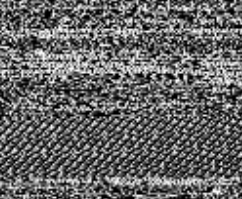

These images are a direct representation of the malware binaries. Each pixel in the image represents a single byte in the binary. The byte can be any value in the 0-255 range. The exact value is represented in the corresponding pixel's brightness. A byte with the value 0 results in a black pixel, a value of 255 results in a white pixel, and a value in between results in the corresponding gray pixel. Each binary byte is fully encoded within the image, meaning the image can be used to exactly reconstruct the binary without any loss of information. Furthermore, the images can visibly convey patterns in the binary. 

---

#### Download the Dataset and Unzip

---

In [4]:
# Downloading the Dataset
import requests
import zipfile
import io

# URL of the dataset
url = "https://www.kaggle.com/api/v1/datasets/download/ikrambenabd/malimg-original"

# Download the dataset
response = requests.get(url)
if response.status_code == 200:
    print("Download Successful.")
else:
    print("Failed to download the dataset.")

Download Successful.


In [5]:
# Unzipping the dataset
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("malimg-original")
    print("Extraction Complete")

# Verify complete extraction
import os
extracted_files = os.listdir("malimg-original")
print("Extracted files: ", extracted_files)

Extraction Complete
Extracted files:  ['malimg_paper_dataset_imgs']


#### Exploring the Dataset

We can start by creating a plot of the class distribution within the dataset. That will let us spot classes that are over- or under represented.

---

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# This will let us iterate over all malware families and count the number of images within the corresponding folder to compute the overall class distribution
DATA_BASE_PATH = "./malimg-original/malimg_paper_dataset_imgs/"

In [8]:
# Compute the class distribution
dist = {}
for mlw_class in os.listdir(DATA_BASE_PATH):
    mlw_dir = os.path.join(DATA_BASE_PATH, mlw_class)
    dist[mlw_class] = len(os.listdir(mlw_dir))

#### Create a barplot to visualize the class distribution
Warning: Actions like these take up a lot of CPU/memory- your Kernel may crash. If it does, research how to add more resources to your Jupyter kernel (I am using Anaconda). You will need to locate your Jupyter configuration file and add `c.NotebookApp.max_buffer_size = 10000000000  # Set a higher buffer size (10GB)` for example, but be aware of how much your host has for resources when computing this number.

---

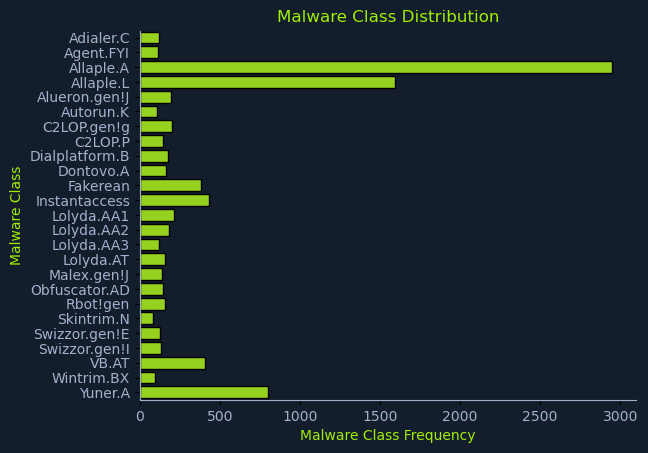

In [10]:
# Plot the class distribution

# HTB Color Palette
htb_green = "#9FEF00"
node_black = "#141D2B"
hacker_grey = "#A4B1CD"

# data
classes = list(dist.keys())
frequencies = list(dist.values())

# plot
plt.figure(facecolor=node_black)
sns.barplot(y=classes, x=frequencies, edgecolor = "black", orient='h', color=htb_green)
plt.title("Malware Class Distribution", color=htb_green)
plt.xlabel("Malware Class Frequency", color=htb_green)
plt.ylabel("Malware Class", color=htb_green)
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
ax = plt.gca()
ax.set_facecolor(node_black)
ax.spines['bottom'].set_color(hacker_grey)
ax.spines['top'].set_color(node_black)
ax.spines['right'].set_color(node_black)
ax.spines['left'].set_color(hacker_grey)
plt.show()

# Preprocessing the Malware Dataset

---

#### Preparing the Datasets
We will split the data into two distinct datasets, one for training and one for testing with the 'spkit-folders' library.

This will create a new directory in the current working directory, 'newdata', that holds a test, train, and val folder structure for each corresponding dataset

---

In [13]:
!pip3 install split-folders

In [14]:
# This will let us split the data with an 80-20 split (training /testing)
import splitfolders

DATA_BASE_PATH = "./malimg-original/malimg_paper_dataset_imgs/"
TARGET_BASE_PATH = "./newdata/"

TRAINING_RATIO = 0.8
TEST_RATIO = 1 - TRAINING_RATIO

splitfolders.ratio(input=DATA_BASE_PATH, output=TARGET_BASE_PATH, ratio=(TRAINING_RATIO, 0, TEST_RATIO))

Copying files: 9339 files [00:02, 3259.61 files/s]


#### Applying Preprocessing & Creating DataLoaders
After a successful image split, we will create DataLoaders for training and inference and apply the required preprocessing to images. Starting with defining the preprocessing model required to read the data. CNNs require a resizing to all input images to reflect the same size and a normalization (ensuring data is standardized before the data is fed to the model). This creates an easier to train model, which we can construct with PyTorch.

---

In [16]:
#!pip3 install torchvision

In [17]:
from torchvision import transforms

# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Now we can load the datasets from their corresponding folders and apply the preprocessing functions. We specify the root folder for each dataset in the root parameter and the preprocessing transform in the transform parameter. The root folders for the datasets are `./newdata/train/` and `./newdata/test`, we will not need 'val'.

---

In [19]:
from torchvision.datasets import ImageFolder
import os

BASE_PATH = "./newdata"

# Load training and test datasets
train_dataset = ImageFolder(
    root=os.path.join(BASE_PATH, "train"),
    transform = transform
)

test_dataset = ImageFolder(
    root=os.path.join(BASE_PATH, "test"),
    transform = transform
)

Now we can create DataLoader instances, that can be used to iterate over the data for training and inference. We can supply a batch size and specify the number of workers to load the data in the `num_workers` parameter. This enables parallelization and will speed up the data handling.


----

In [21]:
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Create data loaders
train_loader = DataLoader(
    train_dataset,
	batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
    
test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

#### Taking a look at one of the preprocessed images to see the effect

----

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.367669].


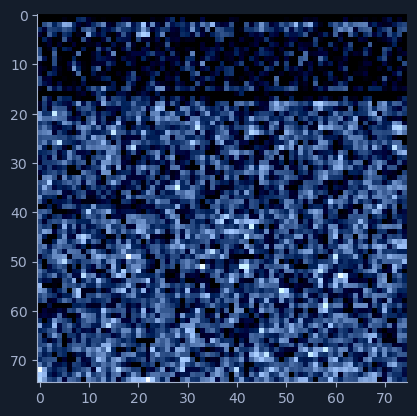

In [23]:
import matplotlib.pyplot as plt

# HTB Color Palette
htb_green = "#9FEF00"
node_black = "#141D2B"
hacker_grey = "#A4B1CD"

# image
sample = next(iter(train_loader))[0][0]

# plot
plt.figure(facecolor=node_black)
plt.imshow(sample.permute(1,2,0))
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
ax = plt.gca()
ax.set_facecolor(node_black)
ax.spines['bottom'].set_color(hacker_grey)
ax.spines['top'].set_color(node_black)
ax.spines['right'].set_color(node_black)
ax.spines['left'].set_color(hacker_grey)
ax.tick_params(axis='x', colors=hacker_grey)
ax.tick_params(axis='y', colors=hacker_grey)
plt.show()

After combining the above code into a single function, we end up with the following code:

In [25]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

def load_datasets(base_path, train_batch_size, test_batch_size):
    # Define preprocessing transforms
    transform = transforms.Compose([
        transforms.Resize((75, 75)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load training and test datasets
    train_dataset = ImageFolder(
        root=os.path.join(base_path, "train"),
        transform=transform
    )

    test_dataset = ImageFolder(
        root=os.path.join(base_path, "test"),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )

    n_classes = len(train_dataset.classes)
    return train_loader, test_loader, n_classes

# The Convolutional Neural Network (CNN) Model
We will base our model on a pre-trained version of a CNN called ResNet50. The ResNet family of CNNs was proposed in 2015 in this [paper](https://arxiv.org/pdf/1512.03385). This is a 50 layer deep model (hence the name), with roughly 23 million parameters. This model is strong in image classification tasks, which perfectly fit a malware classification task.

To speed up the training process, we avoid randomnly initialized weights, with a pre-trained ResNet50. The code will download pre-trained weights and apply them to the model with a baseline. We then can run the training on the malware image dataset to fine-tune it for our purpose, which saves days/weeks of time.

To further speed the process- we freeze the weights of all ResNet layers except for the final one. So only during training will the weights of the final layer change. This will reduce the classifier's performance but benefit our training time and be a good trade-off for this simple experiment. We will adjust the number of neurons in the final layer and fix the output size to the number of classes in our training data. This results in the following MalwareClassifier class:

---

In [27]:
import torch.nn as nn
import torchvision.models as models

HIDDEN_LAYER_SIZE = 1000

class MalwareClassifier(nn.Module):
    def __init__(self, n_classes):
        super(MalwareClassifier, self).__init__()
        # Load pretrained ResNet50
        self.resnet = models.resnet50(weights='DEFAULT')
        
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the last fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, HIDDEN_LAYER_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_SIZE, n_classes)
        )

    def forward(self, x):
        return self.resnet(x)

#### Specify the number of classes
Since our dataset consists of 25 classes, we can initialize the model like so-

---

In [29]:
model = MalwareClassifier(25)

However, as discussed in the previous section, the advantage of dynamically setting the number of classes is that we can directly use it from the dataset. By combining the above code with the code from the previous section, we can take the number of classes from the dataset and initialize the model accordingly:

In [31]:
DATA_PATH = "./newdata/"
TRAINING_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Load datasets
train_loader, test_loader, n_classes = load_datasets(DATA_PATH, TRAINING_BATCH_SIZE, TEST_BATCH_SIZE)

# Initialize model
model = MalwareClassifier(n_classes)

# Training and Evaluation (Malware Image Classification)

---

#### Training
We will define a training function that takes a model, a training loader, and the number of epochs. We then specify the loss function as CrossEntropyLoss and use the Adam Optimizer. Then we iterate the entire training data for each epoch and run the forward and backward passes.

The final trainign function like like this:

----

In [34]:
import torch
import time

def train(model, train_loader, n_epochs, verbose=False):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    training_data = {"accuracy": [], "loss": []}
    
    for epoch in range(n_epochs):
        running_loss = 0
        n_total = 0
        n_correct = 0
        checkpoint = time.time() * 1000
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            n_total += labels.size(0)
            n_correct += predicted.eq(labels).sum().item()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_duration = int(time.time() * 1000 - checkpoint)
        epoch_accuracy = compute_accuracy(n_correct, n_total)
        
        training_data["accuracy"].append(epoch_accuracy)
        training_data["loss"].append(epoch_loss)
        
        if verbose:
            print(f"[i] Epoch {epoch+1} of {n_epochs}: Acc: {epoch_accuracy:.2f}% Loss: {epoch_loss:.4f} (Took {epoch_duration} ms).")    
    
    return training_data

In [35]:
# Define a function to save hte trained model to disk for later use
def save_model(model, path):
	model_scripted = torch.jit.script(model)
	model_scripted.save(path)

#### Evaluation
To evaluate the model we will define a function that runs the model on a single input and returns the predicted class.

---

In [37]:
def predict(model, test_data):
    model.eval()

    with torch.no_grad():
        output = model(test_data)
        _, predicted = torch.max(output.data, 1)

    return predicted

We set the model to evaluation mode using the call model.eval() and disable gradient calculation using torch.no_grad(). From there, we can write an evaluation function that iterates over the entire test dataset and evaluates the model's performance in terms of accuracy:

In [39]:
def compute_accuracy(n_correct, n_total):
    return round(100 * n_correct / n_total, 2)


def evaluate(model, test_loader):
    model.eval()

    n_correct = 0
    n_total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            predicted = predict(model, data)
            n_total += target.size(0)
            n_correct += (predicted == target).sum().item()

    accuracy = compute_accuracy(n_correct, n_total)  

    return accuracy


#### Plots
We then define a couple of helper functions that create simple plots for the training accuracy and loss per epoch:


---

In [41]:
import matplotlib.pyplot as plt

def plot(data, title, label, xlabel, ylabel):
    # HTB Color Palette
    htb_green = "#9FEF00"
    node_black = "#141D2B"
    hacker_grey = "#A4B1CD"

    # plot
    plt.figure(figsize=(10, 6), facecolor=node_black)
    plt.plot(range(1, len(data)+1), data, label=label, color=htb_green)
    plt.title(title, color=htb_green)
    plt.xlabel(xlabel, color=htb_green)
    plt.ylabel(ylabel, color=htb_green)
    plt.xticks(color=hacker_grey)
    plt.yticks(color=hacker_grey)
    ax = plt.gca()
    ax.set_facecolor(node_black)
    ax.spines['bottom'].set_color(hacker_grey)
    ax.spines['top'].set_color(node_black)
    ax.spines['right'].set_color(node_black)
    ax.spines['left'].set_color(hacker_grey)

    legend = plt.legend(facecolor=node_black, edgecolor=hacker_grey, fontsize=10)
    plt.setp(legend.get_texts(), color=htb_green)
    
    plt.show()

def plot_training_accuracy(training_data):
    plot(training_data['accuracy'], "Training Accuracy", "Accuracy", "Epoch", "Accuracy (%)")

def plot_training_loss(training_data):
    plot(training_data['loss'], "Training Loss", "Loss", "Epoch", "Loss")

#### Running the Code
After defining all helper functions, we can write a script that defines all parameters and runs the helper functions to load the data, initialize the model, train the model, save the model, and finally evaluate the model:

---

[i] Starting Training...
[i] Epoch 1 of 10: Acc: 58.91% Loss: 1.4635 (Took 29504 ms).
[i] Epoch 2 of 10: Acc: 86.74% Loss: 0.4283 (Took 25384 ms).
[i] Epoch 3 of 10: Acc: 90.94% Loss: 0.2629 (Took 25215 ms).
[i] Epoch 4 of 10: Acc: 93.07% Loss: 0.2048 (Took 26243 ms).
[i] Epoch 5 of 10: Acc: 94.01% Loss: 0.1790 (Took 24746 ms).
[i] Epoch 6 of 10: Acc: 95.17% Loss: 0.1491 (Took 25116 ms).
[i] Epoch 7 of 10: Acc: 95.86% Loss: 0.1251 (Took 25354 ms).
[i] Epoch 8 of 10: Acc: 96.49% Loss: 0.1125 (Took 25181 ms).
[i] Epoch 9 of 10: Acc: 96.54% Loss: 0.1076 (Took 25664 ms).
[i] Epoch 10 of 10: Acc: 97.20% Loss: 0.0942 (Took 26383 ms).
[i] Inference accuracy: 89.89%.


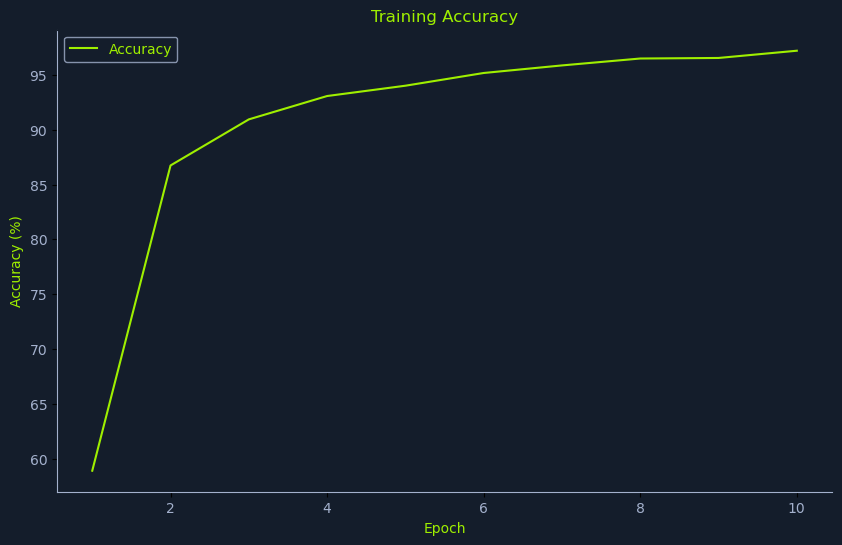

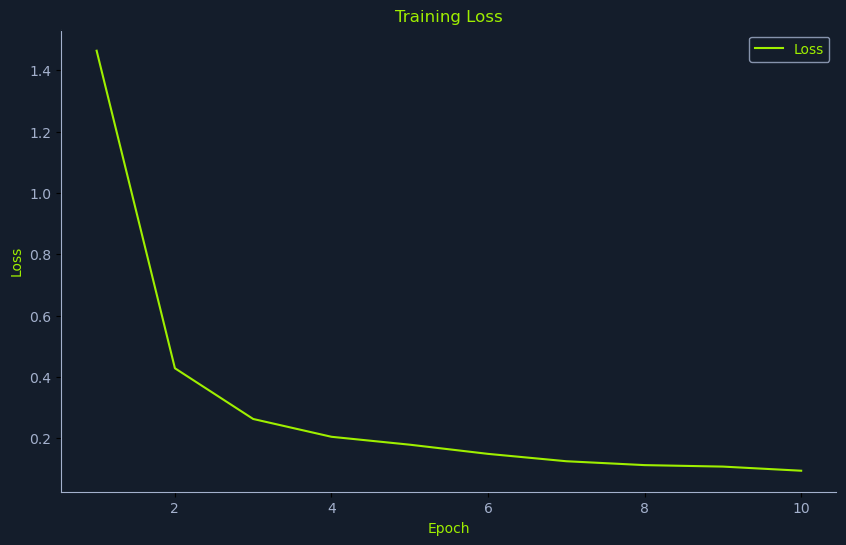

In [43]:
# data parameters
DATA_PATH = "./newdata/"

# training parameters
N_EPOCHS = 10
TRAINING_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1024

# model parameters
HIDDEN_LAYER_SIZE = 1000
MODEL_FILE = "malware_classifier.pth"


# Load datasets
train_loader, test_loader, n_classes = load_datasets(DATA_PATH, TRAINING_BATCH_SIZE, TEST_BATCH_SIZE)

# Initialize model
model = MalwareClassifier(n_classes)

# Train model
print("[i] Starting Training...")  
training_information = train(model, train_loader, N_EPOCHS, verbose=True)

# Save model
save_model(model, MODEL_FILE)

# evaluate model
accuracy = evaluate(model, test_loader)
print(f"[i] Inference accuracy: {accuracy}%.")  

# Plot training details
plot_training_accuracy(training_information)
plot_training_loss(training_information)

# Uploading the Model to Hack The Box's Endpoint for flag

I cleared the output of the flag in order to encourage those who may land here to do the work themselves.



----

In [ ]:
import requests
import json

# Define the URL of the API endpoint
url = "http://10.129.45.125:8002/api/upload"

# Path to the model file you want to upload
model_file_path = "malware_classifier.pth"

# Open the file in binary mode and send the POST request
with open(model_file_path, "rb") as model_file:
    files = {"model": model_file}
    response = requests.post(url, files=files)

# Pretty print the response from the server
print(json.dumps(response.json(), indent=4))